In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from agent import *
from selection import *
from utils import *
from env import Environment, StochasticGameEnvironment
from simulation import *
from main import Config
from tqdm import tqdm
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import ticker

In [2]:
seed_everything()
config = {
    'reward': 3, 
    'sucker': 0, 
    'temptation': 5, 
    'punishment': 1, 
    'n_episodes': 10000, 
    'discount': 0.99,
    'play_epsilon': 1,
    'select_epsilon': 1,
    'epsilon_decay': 0.995,
    'min_epsilon': 0.01,
    'alpha': 0.1,
    'n_actions': 2,
    'h': 5,
    'select_h': 5,
    'state_repr': 'bi',
    'batch_size': 64,
    'learning_rate': 1e-3,
}
torch.cuda.is_available()

True

In [3]:
def check_convergence(agents: dict[int, object], thresh: tuple, k: int, last_reward: dict[int, float]):
    strategy_convergent_episode = {}
    reward_convergent_episode = {}
    thresh_strategy, thresh_reward = thresh[0], thresh[1]

    for n in agents:
        # Strategy convergence
        strategy_convergent = agents[n].determine_convergence(thresh_strategy, k)
        if strategy_convergent:
            strategy_convergent_episode[n] = agents[n].play_times

        # reward convergence
        if np.abs(agents[n].running_score-last_reward[n]) <= thresh_reward:
            reward_convergent_episode[n] = agents[n].play_times

    return strategy_convergent_episode, reward_convergent_episode

# Prisoner's Dilemma

In [4]:
reward, temptation, sucker, punishment = generate_payoff_matrix('PD', N=100)
k = 1000
config['h'] = 5
config['n_episodes'] = 30000  # convergent threshold
config['epsilon_decay'] = 0.995
thresh_strategy = k * config['min_epsilon'] + 5
thresh_network = k/100
thresh_reward = 1
thresh = (thresh_strategy, thresh_reward, thresh_network)

### DRQN

In [5]:
df_normal_pd = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                  'agent2_strategy', 'agent2_reward', 
                                  'temptation', 'reward', 'punishment', 'sucker', 
                                  'agent1_final_strategy', 'agent1_defection_ratio',
                                  'agent2_final_strategy', 'agent2_defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            with HiddenPrints():
                env.play(agent1, agent2, k)
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_normal_pd.loc[len(df_normal_pd.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                           convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                           float(torch.sum(agent1.own_memory)/agent1.play_times),
                                           round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                           float(torch.sum(agent2.own_memory)/agent2.play_times)]

100it [1:44:48, 62.89s/it]


### Alternative DRQN

In [6]:
df_alter_pd = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                  'agent2_strategy', 'agent2_reward', 
                                  'temptation', 'reward', 'punishment', 'sucker', 
                                  'agent1_final_strategy', 'agent1_defection_ratio',
                                  'agent2_final_strategy', 'agent2_defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            TwoAgentSimulation.two_agent_alter_learning(agent1, agent2, config_obj, env, k)
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_alter_pd.loc[len(df_alter_pd.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                           convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                           float(torch.sum(agent1.own_memory)/agent1.play_times),
                                           round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                           float(torch.sum(agent2.own_memory)/agent2.play_times)]

100it [58:27, 35.07s/it]


### Episodic DRQN

In [7]:
df_episodic_pd = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                       'agent2_strategy', 'agent2_reward', 
                                       'temptation', 'reward', 'punishment', 'sucker', 
                                       'agent1_final_strategy', 'agent1_defection_ratio',
                                       'agent2_final_strategy', 'agent2_defection_ratio',
                                       'agent1_updating_times', 'agent2_updating_times'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config['epsilon_decay'] = 0.99
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthority(config_obj, agents, k, settlement_prob=0.005, update_times=20)

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_episodic_pd.loc[len(df_episodic_pd.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                            convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                            config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                            round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                            float(torch.sum(agent1.own_memory)/agent1.play_times),
                                            round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                            float(torch.sum(agent2.own_memory)/agent2.play_times),
                                            agents[0].updating_times[1], agents[1].updating_times[0]]

100it [55:10, 33.11s/it]


In [292]:
df_normal_pd['agent1_updating_times'] = df_normal_pd[['agent1_strategy','agent1_reward']].max(axis=1) - config['batch_size']
df_normal_pd['agent2_updating_times'] = df_normal_pd[['agent2_strategy','agent2_reward']].max(axis=1) - config['batch_size']
df_alter_pd['agent1_updating_times'] = (df_alter_pd[['agent1_strategy','agent1_reward']].max(axis=1))/4
df_alter_pd['agent2_updating_times'] = (df_alter_pd[['agent2_strategy','agent2_reward']].max(axis=1))/4
df_normal_pd['model'] = 'normal'
df_alter_pd['model'] = 'alternative'
df_episodic_pd['model'] = 'episodic'
df_pd = pd.concat([df_normal_pd, df_alter_pd],ignore_index=True)
df_pd = pd.concat([df_pd, df_episodic_pd],ignore_index=True)
df_pd.to_csv('2_agent_pd.csv',index=False)

In [293]:
df_pd[df_pd.isna().any(axis=1)]

,agent1_strategy,agent1_reward,agent2_strategy,agent2_reward,temptation,reward,punishment,sucker,agent1_final_strategy,agent1_defection_ratio,agent2_final_strategy,agent2_defection_ratio,agent1_updating_times,agent2_updating_times,model
1,30000.0,NaN,NaN,NaN,1.60,1.0,0.0,-0.06,1.0,0.782267,1.0,0.775133,29936.0,NaN,normal
11,NaN,NaN,NaN,NaN,1.01,1.0,0.0,-0.04,1.0,0.790233,1.0,0.717933,NaN,NaN,normal
33,NaN,NaN,NaN,NaN,1.23,1.0,0.0,-0.06,0.0,0.540733,1.0,0.542000,NaN,NaN,normal
43,NaN,NaN,NaN,NaN,1.20,1.0,0.0,-0.10,0.0,0.543667,0.0,0.475333,NaN,NaN,normal
50,NaN,NaN,NaN,NaN,1.92,1.0,0.0,-0.04,0.0,0.705033,0.0,0.577367,NaN,NaN,normal
53,NaN,NaN,NaN,NaN,1.44,1.0,0.0,-0.11,1.0,0.718967,1.0,0.561933,NaN,NaN,normal
55,NaN,NaN,NaN,30000.0,1.12,1.0,0.0,-0.09,0.0,0.708700,1.0,0.664367,NaN,29936.0,normal
69,NaN,NaN,NaN,NaN,1.52,1.0,0.0,-0.02,0.0,0.706100,1.0,0.522367,NaN,NaN,normal
88,NaN,NaN,NaN,NaN,1.50,1.0,0.0,-0.12,0.0,0.551233,0.0,0.731233,NaN,NaN,normal
94,NaN,NaN,NaN,NaN,1.29,1.0,0.0,-0.24,1.0,0.675433,1.0,0.648967,NaN,NaN,normal


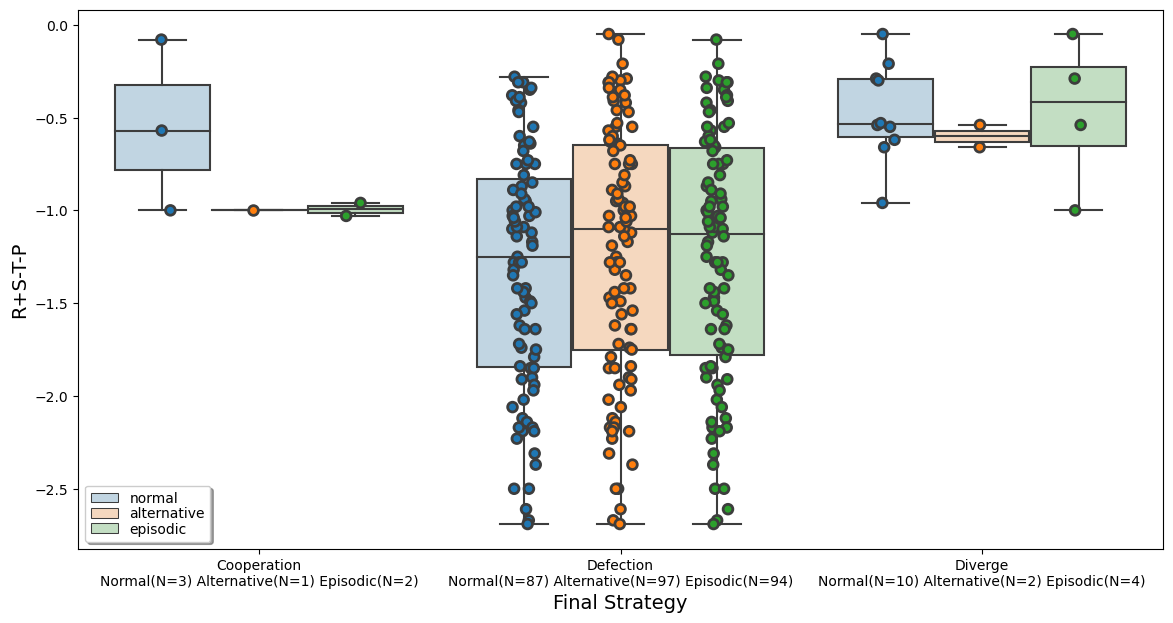

In [294]:
df_pd_plot = df_pd.copy()
df_pd_plot.loc[df_pd_plot.agent1_reward.isnull(), 'agent1_final_strategy'] = np.inf
df_pd_plot.loc[df_pd_plot.agent1_strategy.isnull(), 'agent1_final_strategy'] = np.inf
df_pd_plot.loc[df_pd_plot.agent2_reward.isnull(), 'agent2_final_strategy'] = np.inf
df_pd_plot.loc[df_pd_plot.agent2_strategy.isnull(), 'agent2_final_strategy'] = np.inf

df_pd_plot.temptation = df_pd_plot.temptation/df_pd_plot.reward
df_pd_plot.sucker = df_pd_plot.sucker/df_pd_plot.reward
df_pd_plot['new_reward'] = 1.0
df_pd_plot['R+S-T-P'] = df_pd_plot['reward'] + df_pd_plot['sucker'] - df_pd_plot['temptation'] - df_pd_plot['punishment']

plt.figure(figsize=(14, 7))
ax = sns.boxplot(data=df_pd_plot, x="agent1_final_strategy", y="R+S-T-P", hue="model")
# for violin, alpha in zip(ax.collections[::2], [0.7,0.7,0.7,0.7,0.7,0.7]):
#     violin.set_alpha(alpha)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.stripplot(x = 'agent1_final_strategy', y = 'R+S-T-P',  hue='model', data = df_pd_plot, marker='o',
              size=7, linewidth=2, dodge=True)

plt.xlim(-0.5,2.5)

df_pd_plot_noraml = df_pd_plot.loc[df_pd_plot.model=='normal']
df_pd_plot_altern = df_pd_plot.loc[df_pd_plot.model=='alternative']
df_pd_plot_episod = df_pd_plot.loc[df_pd_plot.model=='episodic']
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([f"Cooperation\nNormal(N={sum(df_pd_plot_noraml['agent1_final_strategy']==0)}) Alternative(N={sum(df_pd_plot_altern['agent1_final_strategy']==0)}) Episodic(N={sum(df_pd_plot_episod['agent1_final_strategy']==0)})", 
                    f"Defection\nNormal(N={sum(df_pd_plot_noraml['agent1_final_strategy']==1)}) Alternative(N={sum(df_pd_plot_altern['agent1_final_strategy']==1)}) Episodic(N={sum(df_pd_plot_episod['agent1_final_strategy']==1)})", 
                    f"Diverge\nNormal(N={sum(df_pd_plot_noraml['agent1_final_strategy']==np.inf)}) Alternative(N={sum(df_pd_plot_altern['agent1_final_strategy']==np.inf)}) Episodic(N={sum(df_pd_plot_episod['agent1_final_strategy']==np.inf)})"])
plt.xlabel('Final Strategy', fontsize=14)
plt.ylabel('R+S-T-P', fontsize=14)
# plt.legend(loc='lower right', shadow=True)
lines, labels = ax.get_legend_handles_labels()
plt.legend(lines[:3], labels[:3], scatterpoints=1, frameon=True, labelspacing=.1, markerscale=.14, shadow=True)

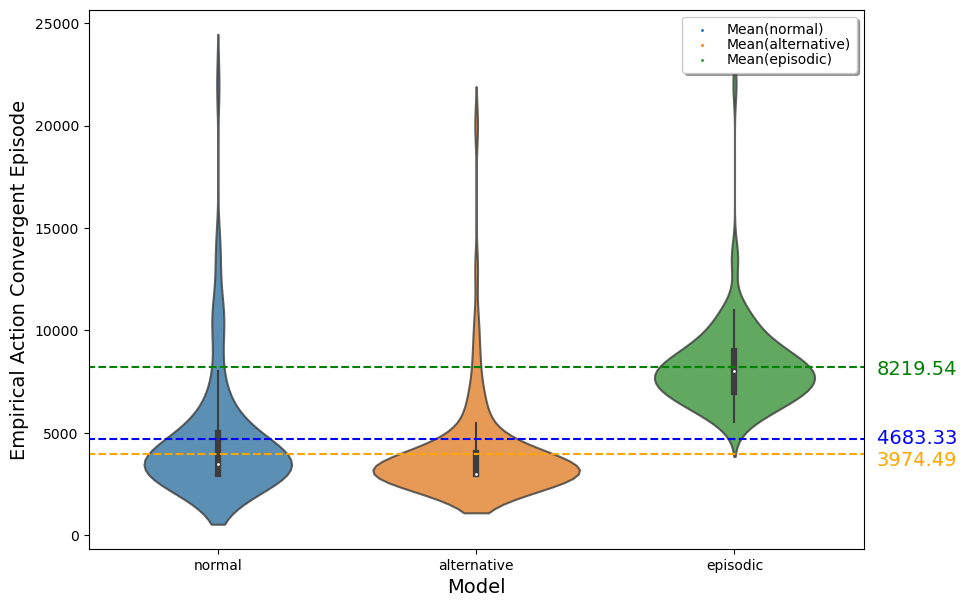

In [296]:
df_pd_plot['strategy_episode'] = (df_pd_plot['agent1_strategy'] + df_pd_plot['agent2_strategy'])/2
df_pd_plot['reward_episode'] = (df_pd_plot['agent1_reward'] + df_pd_plot['agent2_reward'])/2
df_pd_plot.dropna(inplace=True)

plt.figure(figsize=(10, 7))
ax = sns.violinplot(data=df_pd_plot, x="model", y="strategy_episode")
# sns.violinplot(data=df_pd_plot, x="model", y="reward_episode")

for violin, alpha in zip(ax.collections[::2], [0.8,0.8,0.8,0.8,0.8,0.8]):
    violin.set_alpha(alpha)
plt.hlines(np.mean(df_pd_plot.loc[df_pd_plot.model=='normal', 'strategy_episode']), -1, 4, 'blue', '--', label='Mean(normal)')
plt.hlines(np.mean(df_pd_plot.loc[df_pd_plot.model=='alternative', 'strategy_episode']), -1, 4, 'orange', '--', label='Mean(alternative)')
plt.hlines(np.mean(df_pd_plot.loc[df_pd_plot.model=='episodic', 'strategy_episode']), -1, 4, 'green', '--', label='Mean(episodic)')
plt.text(2.55, np.mean(df_pd_plot.loc[df_pd_plot.model=='normal', 'strategy_episode'])-200, f"{round(np.mean(df_pd_plot.loc[df_pd_plot.model=='normal', 'strategy_episode']),2)}", c='blue', fontsize=14)
plt.text(2.55, np.mean(df_pd_plot.loc[df_pd_plot.model=='alternative', 'strategy_episode'])-600, f"{round(np.mean(df_pd_plot.loc[df_pd_plot.model=='alternative', 'strategy_episode']),2)}", c='orange', fontsize=14)
plt.text(2.55, np.mean(df_pd_plot.loc[df_pd_plot.model=='episodic', 'strategy_episode'])-400, f"{round(np.mean(df_pd_plot.loc[df_pd_plot.model=='episodic', 'strategy_episode']),2)}", c='green', fontsize=14)
plt.xlim(-0.5,2.5)

xticks_list = []
xticklabels_list = []
for i in ax.get_xticklabels():
    try:
        xticks_list.append(i.get_position()[0])
        xticklabels_list.append(int(float(i.get_text())))
    except: 
        xticklabels_list.append(i.get_text())
ax.set_xticks(xticks_list)
ax.set_xticklabels(xticklabels_list)

plt.xlabel('Model', fontsize=14)
plt.ylabel('Empirical Action Convergent Episode', fontsize=14)
ines, labels = ax.get_legend_handles_labels()
plt.legend(lines[-3:], labels[-3:], scatterpoints=1, frameon=True, labelspacing=.1, markerscale=.14, shadow=True)

Text(0, 0.5, 'Update Times ($log_{10}$)')

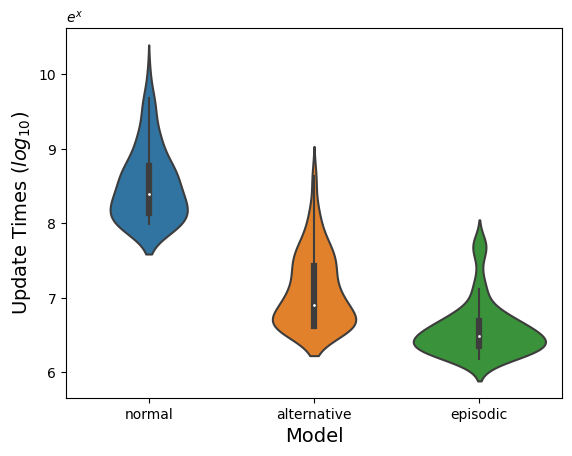

In [295]:
df_pd_plot['update_times'] = np.log((df_pd_plot['agent1_updating_times'] + df_pd_plot['agent2_updating_times'])/2)
ax = sns.violinplot(data=df_pd_plot, x="model", y="update_times")
plt.text(-.0, 1.05, '$e^x$', ha='left', va='top', transform=ax.transAxes)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Update Times ($log_{10}$)', fontsize=14)

# Stag Hunt

In [9]:
reward, temptation, sucker, punishment = generate_payoff_matrix('SH', N=100)
k = 1000
config['h'] = 5
config['n_episodes'] = 30000  # convergent threshold
config['epsilon_decay'] = 0.995
thresh_strategy = k * config['min_epsilon'] + 5
thresh_network = k/100
thresh_reward = 1
thresh = (thresh_strategy, thresh_reward, thresh_network)

### DRQN

In [10]:
df_normal_sh = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                  'agent2_strategy', 'agent2_reward', 
                                  'temptation', 'reward', 'punishment', 'sucker', 
                                  'agent1_final_strategy', 'agent1_defection_ratio',
                                  'agent2_final_strategy', 'agent2_defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            with HiddenPrints():
                env.play(agent1, agent2, k)
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_normal_sh.loc[len(df_normal_sh.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                           convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                           float(torch.sum(agent1.own_memory)/agent1.play_times),
                                           round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                           float(torch.sum(agent2.own_memory)/agent2.play_times)]

100it [1:07:35, 40.55s/it]


### Alternative DRQN

In [11]:
df_alter_sh = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                  'agent2_strategy', 'agent2_reward', 
                                  'temptation', 'reward', 'punishment', 'sucker', 
                                  'agent1_final_strategy', 'agent1_defection_ratio',
                                  'agent2_final_strategy', 'agent2_defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            TwoAgentSimulation.two_agent_alter_learning(agent1, agent2, config_obj, env, k)
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_alter_sh.loc[len(df_alter_sh.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                           convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                           float(torch.sum(agent1.own_memory)/agent1.play_times),
                                           round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                           float(torch.sum(agent2.own_memory)/agent2.play_times)]

100it [49:07, 29.48s/it]


### Episodic DRQN

In [12]:
df_episodic_sh = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                   'agent2_strategy', 'agent2_reward', 
                                   'temptation', 'reward', 'punishment', 'sucker', 
                                   'agent1_final_strategy', 'agent1_defection_ratio',
                                   'agent2_final_strategy', 'agent2_defection_ratio',
                                   'agent1_updating_times', 'agent2_updating_times'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    config['epsilon_decay'] = 0.99
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthority(config_obj, agents, k, settlement_prob=0.005, update_times=20)

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_episodic_sh.loc[len(df_episodic_sh.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                            convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                            config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                            round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                            float(torch.sum(agent1.own_memory)/agent1.play_times),
                                            round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                            float(torch.sum(agent2.own_memory)/agent2.play_times),
                                            agents[0].updating_times[1], agents[1].updating_times[0]]

100it [52:09, 31.30s/it]


In [297]:
df_normal_sh['agent1_updating_times'] = df_normal_sh[['agent1_strategy','agent1_reward']].max(axis=1) - config['batch_size']
df_normal_sh['agent2_updating_times'] = df_normal_sh[['agent2_strategy','agent2_reward']].max(axis=1) - config['batch_size']
df_alter_sh['agent1_updating_times'] = (df_alter_sh[['agent1_strategy','agent1_reward']].max(axis=1))/4
df_alter_sh['agent2_updating_times'] = (df_alter_sh[['agent2_strategy','agent2_reward']].max(axis=1))/4
df_normal_sh['model'] = 'normal'
df_alter_sh['model'] = 'alternative'
df_episodic_sh['model'] = 'episodic'
df_sh = pd.concat([df_normal_sh, df_alter_sh],ignore_index=True)
df_sh = pd.concat([df_sh, df_episodic_sh],ignore_index=True)
df_sh.to_csv('2_agent_sh.csv',index=False)

In [298]:
df_sh = df_sh.astype({'agent1_strategy':'int', 'agent1_reward':'int', 
              'agent2_strategy':'int', 'agent2_reward':'int', 
              'agent1_updating_times':'int', 'agent2_updating_times':'int'})

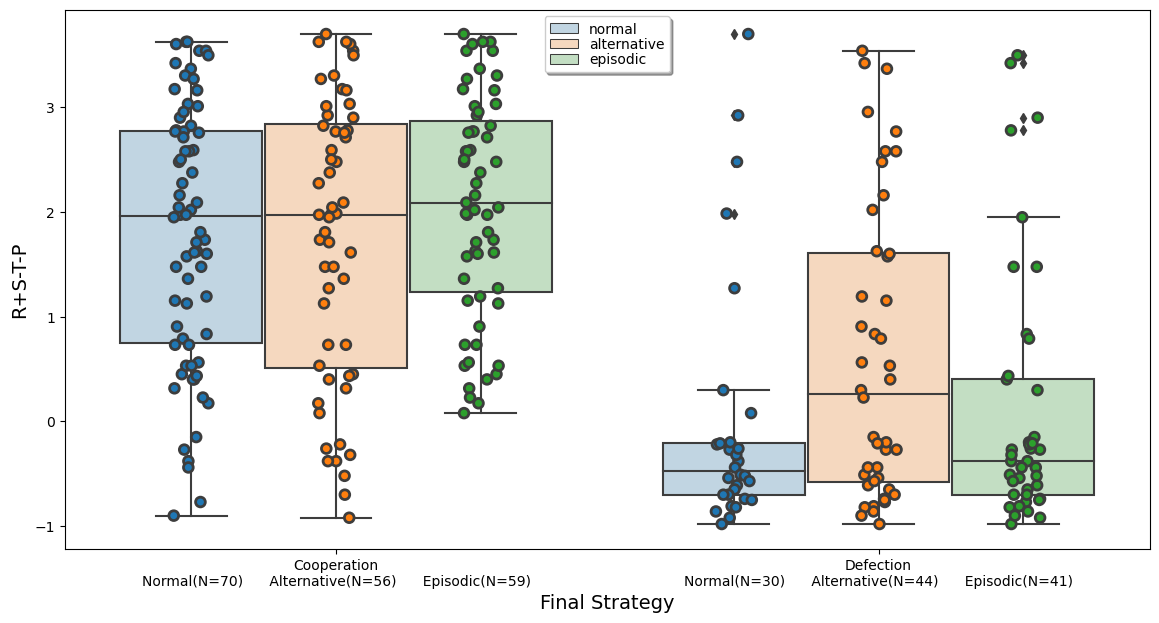

In [299]:
df_sh_plot = df_sh.copy()
df_sh_plot.temptation = df_sh_plot.temptation/df_sh_plot.reward
df_sh_plot.sucker = df_sh_plot.sucker/df_sh_plot.reward
df_sh_plot['new_reward'] = 1.0
df_sh_plot['R+S-T-P'] = df_sh_plot['reward'] + df_sh_plot['sucker'] - df_sh_plot['temptation'] - df_sh_plot['punishment']
df_sh_plot_noraml = df_sh_plot.loc[df_sh_plot.model=='normal']
df_sh_plot_altern = df_sh_plot.loc[df_sh_plot.model=='alternative']
df_sh_plot_episod = df_sh_plot.loc[df_sh_plot.model=='episodic']

plt.figure(figsize=(14, 7))
ax = sns.boxplot(data=df_sh_plot, x="agent1_final_strategy", y="R+S-T-P", hue="model")
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.stripplot(x = 'agent1_final_strategy', y = 'R+S-T-P',  hue='model', data = df_sh_plot, marker='o',
              size=7, linewidth=2, dodge=True)
plt.xlim(-0.5,1.5)
ax.set_xticks([0, 1])
ax.set_xticklabels([f"Cooperation\nNormal(N={sum(df_sh_plot_noraml['agent1_final_strategy']==0)})      Alternative(N={sum(df_sh_plot_altern['agent1_final_strategy']==0)})      Episodic(N={sum(df_sh_plot_episod['agent1_final_strategy']==0)})", 
                    f"Defection\nNormal(N={sum(df_sh_plot_noraml['agent1_final_strategy']==1)})      Alternative(N={sum(df_sh_plot_altern['agent1_final_strategy']==1)})      Episodic(N={sum(df_sh_plot_episod['agent1_final_strategy']==1)})"])
plt.xlabel('Final Strategy', fontsize=14)
plt.ylabel('R+S-T-P', fontsize=14)
# plt.legend(loc='lower right', shadow=True)
lines, labels = ax.get_legend_handles_labels()
plt.legend(lines[:3], labels[:3], scatterpoints=1, frameon=True, labelspacing=.1, markerscale=.14, shadow=True)

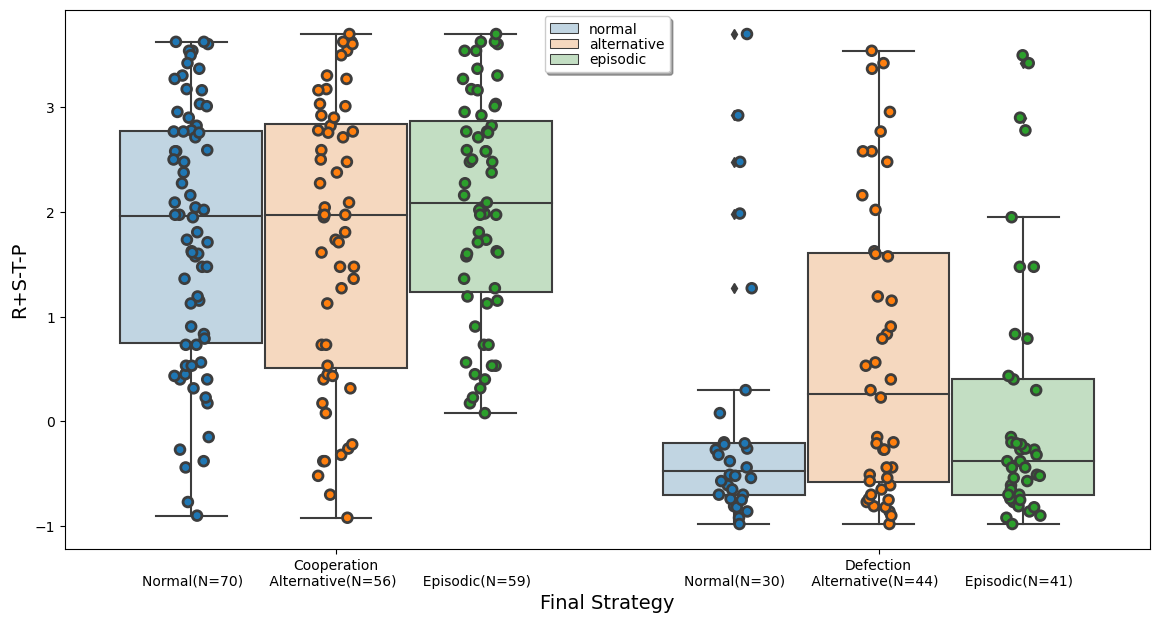

In [270]:
plt.figure(figsize=(14, 7))
ax = sns.boxplot(data=df_sh_plot, x="agent2_final_strategy", y="R+S-T-P", hue="model")
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.stripplot(x = 'agent2_final_strategy', y = 'R+S-T-P',  hue='model', data = df_sh_plot, marker='o',
              size=7, linewidth=2, dodge=True)
plt.xlim(-0.5,1.5)
ax.set_xticks([0, 1])
ax.set_xticklabels([f"Cooperation\nNormal(N={sum(df_sh_plot_noraml['agent2_final_strategy']==0)})      Alternative(N={sum(df_sh_plot_altern['agent2_final_strategy']==0)})      Episodic(N={sum(df_sh_plot_episod['agent2_final_strategy']==0)})", 
                    f"Defection\nNormal(N={sum(df_sh_plot_noraml['agent2_final_strategy']==1)})      Alternative(N={sum(df_sh_plot_altern['agent2_final_strategy']==1)})      Episodic(N={sum(df_sh_plot_episod['agent2_final_strategy']==1)})"])
plt.xlabel('Final Strategy', fontsize=14)
plt.ylabel('R+S-T-P', fontsize=14)
# plt.legend(loc='lower right', shadow=True)
lines, labels = ax.get_legend_handles_labels()
plt.legend(lines[:3], labels[:3], scatterpoints=1, frameon=True, labelspacing=.1, markerscale=.14, shadow=True)

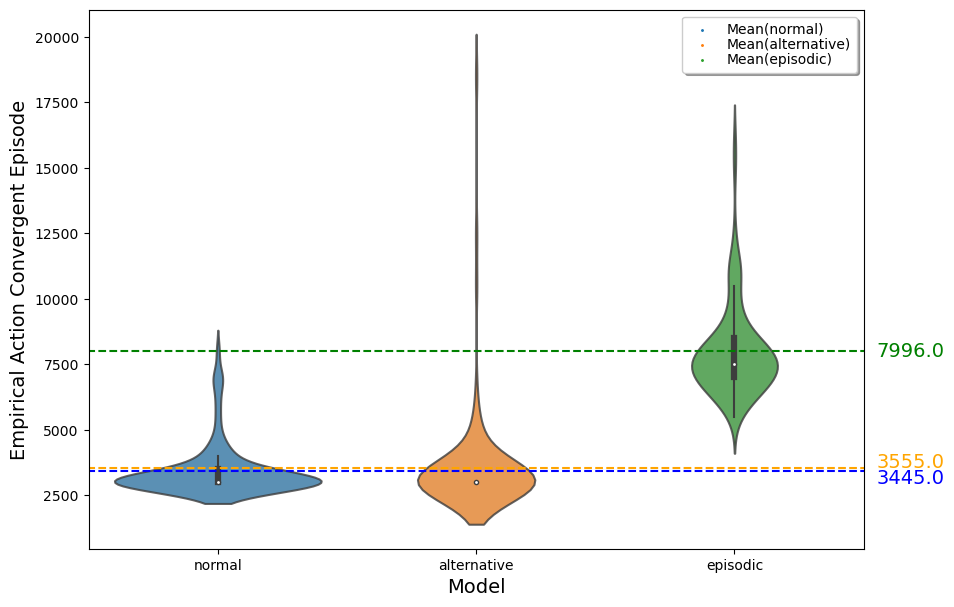

In [300]:
df_sh_plot['strategy_episode'] = (df_sh_plot['agent1_strategy'] + df_sh_plot['agent2_strategy'])/2
df_sh_plot['reward_episode'] = (df_sh_plot['agent1_reward'] + df_sh_plot['agent2_reward'])/2

plt.figure(figsize=(10, 7))
ax = sns.violinplot(data=df_sh_plot, x="model", y="strategy_episode")
# sns.violinplot(data=df_pd_plot, x="model", y="reward_episode")

for violin, alpha in zip(ax.collections[::2], [0.8,0.8,0.8,0.8,0.8,0.8]):
    violin.set_alpha(alpha)
plt.hlines(np.mean(df_sh_plot.loc[df_sh_plot.model=='normal', 'strategy_episode']), -1, 4, 'blue', '--', label='Mean(normal)')
plt.hlines(np.mean(df_sh_plot.loc[df_sh_plot.model=='alternative', 'strategy_episode']), -1, 4, 'orange', '--', label='Mean(alternative)')
plt.hlines(np.mean(df_sh_plot.loc[df_sh_plot.model=='episodic', 'strategy_episode']), -1, 4, 'green', '--', label='Mean(episodic)')
plt.text(2.55, np.mean(df_sh_plot.loc[df_sh_plot.model=='normal', 'strategy_episode'])-500, f"{round(np.mean(df_sh_plot.loc[df_sh_plot.model=='normal', 'strategy_episode']),2)}", c='blue', fontsize=14)
plt.text(2.55, np.mean(df_sh_plot.loc[df_sh_plot.model=='alternative', 'strategy_episode']), f"{round(np.mean(df_sh_plot.loc[df_sh_plot.model=='alternative', 'strategy_episode']),2)}", c='orange', fontsize=14)
plt.text(2.55, np.mean(df_sh_plot.loc[df_sh_plot.model=='episodic', 'strategy_episode'])-200, f"{round(np.mean(df_sh_plot.loc[df_sh_plot.model=='episodic', 'strategy_episode']),2)}", c='green', fontsize=14)
plt.xlim(-0.5,2.5)

xticks_list = []
xticklabels_list = []
for i in ax.get_xticklabels():
    try:
        xticks_list.append(i.get_position()[0])
        xticklabels_list.append(int(float(i.get_text())))
    except: 
        xticklabels_list.append(i.get_text())
ax.set_xticks(xticks_list)
ax.set_xticklabels(xticklabels_list)

plt.xlabel('Model', fontsize=14)
plt.ylabel('Empirical Action Convergent Episode', fontsize=14)
ines, labels = ax.get_legend_handles_labels()
plt.legend(lines[-3:], labels[-3:], scatterpoints=1, frameon=True, labelspacing=.1, markerscale=.14, shadow=True)

Text(0, 0.5, 'Update Times ($log_{10}$)')

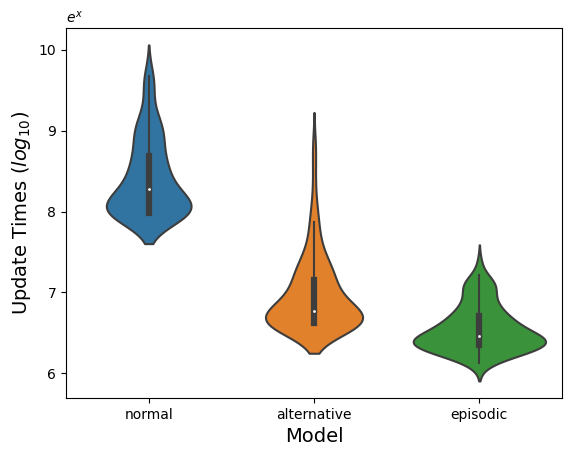

In [301]:
# df_pd_plot['update_times'] = (df_pd_plot['agent1_updating_times'] + df_pd_plot['agent2_updating_times'])/2
df_sh_plot['update_times'] = np.log((df_sh_plot['agent1_updating_times'] + df_sh_plot['agent2_updating_times'])/2)
df_sh_plot_new = df_sh_plot[df_sh_plot['update_times'].map(df_sh_plot['update_times'].value_counts()) > 2]
ax = sns.violinplot(data=df_sh_plot, x="model", y="update_times")
# formatter = ticker.ScalarFormatter(useMathText=True)
# formatter.set_scientific(True) 
# formatter.set_powerlimits((-1,1)) 
# ax.yaxis.set_major_formatter(formatter) 
plt.text(-.0, 1.05, '$e^x$', ha='left', va='top', transform=ax.transAxes)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Update Times ($log_{10}$)', fontsize=14)

# EDA

In [319]:
func = np.mean
print('Normal DRQN')
print(f"PD: Empirical Mean: Agent1:{round(func(df_normal_pd['agent1_strategy']),4)}, Agent2: {round(func(df_normal_pd['agent2_strategy']),4)}")
print(f"PD: Reward    Mean: Agent1:{round(func(df_normal_pd['agent1_reward']),4)}, Agent2: {round(func(df_normal_pd['agent2_reward']),4)}")
print(f"PD: Update    Mean: Agent1:{round(func(df_normal_pd['agent1_updating_times']),4)}, Agent2: {round(func(df_normal_pd['agent2_updating_times']),4)}")
print(f"SH: Empirical Mean: Agent1:{round(func(df_normal_sh['agent1_strategy']),4)}, Agent2: {round(func(df_normal_sh['agent2_strategy']),4)}")
print(f"SH: Reward    Mean: Agent1:{round(func(df_normal_sh['agent1_reward']),4)}, Agent2: {round(func(df_normal_sh['agent2_reward']),4)}")
print(f"SH: Update    Mean: Agent1:{round(func(df_normal_sh['agent1_updating_times']),4)}, Agent2: {round(func(df_normal_sh['agent2_updating_times']),4)}")

print()
print('Alternative DRQN')
print(f"PD: Empirical Mean: Agent1:{round(func(df_alter_pd['agent1_strategy']),4)}, Agent2: {round(func(df_alter_pd['agent2_strategy']),4)}")
print(f"PD: Reward    Mean: Agent1:{round(func(df_alter_pd['agent1_reward']),4)}, Agent2: {round(func(df_alter_pd['agent2_reward']),4)}")
print(f"PD: Update    Mean: Agent1:{round(func(df_alter_pd['agent1_updating_times']),4)}, Agent2: {round(func(df_alter_pd['agent2_updating_times']),4)}")
print(f"SH: Empirical Mean: Agent1:{round(func(df_alter_sh['agent1_strategy']),4)}, Agent2: {round(func(df_alter_sh['agent2_strategy']),4)}")
print(f"SH: Reward    Mean: Agent1:{round(func(df_alter_sh['agent1_reward']),4)}, Agent2: {round(func(df_alter_sh['agent2_reward']),4)}")
print(f"SH: Update    Mean: Agent1:{round(func(df_alter_sh['agent1_updating_times']),4)}, Agent2: {round(func(df_alter_sh['agent2_updating_times']),4)}")

print()
print('Episodic DRQN')
print(f"PD: Empirical Mean: Agent1:{round(func(df_episodic_pd['agent1_strategy']),4)}, Agent2: {round(func(df_episodic_pd['agent2_strategy']),4)}")
print(f"PD: Reward    Mean: Agent1:{round(func(df_episodic_pd['agent1_reward']),4)}, Agent2: {round(func(df_episodic_pd['agent2_reward']),4)}")
print(f"PD: Update    Mean: Agent1:{round(func(df_episodic_pd['agent1_updating_times']),4)}, Agent2: {round(func(df_episodic_pd['agent2_updating_times']),4)}")
print(f"SH: Empirical Mean: Agent1:{round(func(df_episodic_sh['agent1_strategy']),4)}, Agent2: {round(func(df_episodic_sh['agent2_strategy']),4)}")
print(f"SH: Reward    Mean: Agent1:{round(func(df_episodic_sh['agent1_reward']),4)}, Agent2: {round(func(df_episodic_sh['agent2_reward']),4)}")
print(f"SH: Update    Mean: Agent1:{round(func(df_episodic_sh['agent1_updating_times']),4)}, Agent2: {round(func(df_episodic_sh['agent2_updating_times']),4)}")


Normal DRQN
PD: Empirical Mean: Agent1:4890.1099, Agent2: 4755.5556
PD: Reward    Mean: Agent1:5266.6667, Agent2: 5571.4286
PD: Update    Mean: Agent1:6001.9341, Agent2: 5979.956
SH: Empirical Mean: Agent1:3540.0, Agent2: 3350.0
SH: Reward    Mean: Agent1:4880.0, Agent2: 4860.0
SH: Update    Mean: Agent1:5186.0, Agent2: 5136.0

Alternative DRQN
PD: Empirical Mean: Agent1:4333.3333, Agent2: 3785.7143
PD: Reward    Mean: Agent1:4581.6327, Agent2: 5290.0
PD: Update    Mean: Agent1:1376.2626, Agent2: 1467.5
SH: Empirical Mean: Agent1:3690.0, Agent2: 3420.0
SH: Reward    Mean: Agent1:4100.0, Agent2: 4080.0
SH: Update    Mean: Agent1:1235.0, Agent2: 1235.0

Episodic DRQN
PD: Empirical Mean: Agent1:8516.2041, Agent2: 8346.2062
PD: Reward    Mean: Agent1:9387.4433, Agent2: 9480.2268
PD: Update    Mean: Agent1:775.0, Agent2: 775.0
SH: Empirical Mean: Agent1:7826.0, Agent2: 8166.0
SH: Reward    Mean: Agent1:9486.0, Agent2: 9316.0
SH: Update    Mean: Agent1:729.8, Agent2: 729.8


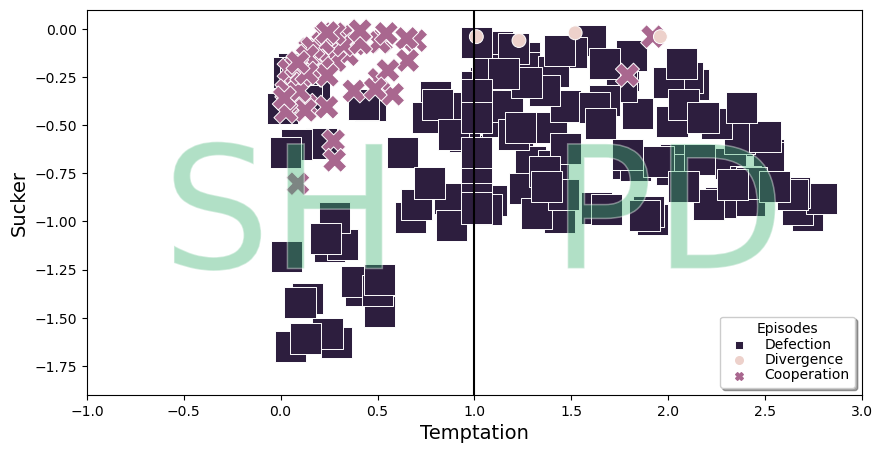

In [350]:
df_pd['game'] = 'PD'
df_sh['game'] = 'SH'
df_all_plot = pd.concat([df_pd, df_sh], ignore_index=True)
df_all_plot.temptation = df_all_plot.temptation/df_all_plot.reward
df_all_plot.sucker = df_all_plot.sucker/df_all_plot.reward
df_all_plot['new_reward'] = 1.0
df_all_plot.loc[df_all_plot.isna().any(axis=1), 'agent1_final_strategy'] = -1
df_all_plot.loc[df_all_plot.isna().any(axis=1), 'agent2_final_strategy'] = -1

plt.figure(figsize=(10, 5))
ax = sns.scatterplot(data=df_all_plot.loc[df_all_plot.model=='episodic'].sort_values(by=['agent1_final_strategy'],ascending=False), 
                     y='sucker', x='temptation', 
                    hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[100,300,500], 
                    linewidth=0.7, alpha=1, style="agent1_final_strategy", markers=['o','X','s'])

lgnd = plt.legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Divergence','Cooperation'], loc='lower right', shadow=True)

plt.vlines(1, -2, 10, 'black')
# plt.hlines(0, -10, 10, 'black')

t = ax.text(2, -1, "PD", alpha = .1, animated = True, fontsize = 123, ha = "center", va = "center")
t.set_path_effects([
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.4)])

t = ax.text(0, -1, "SH", alpha = .5, animated = True,
       fontsize = 123, fontstyle = "normal", color = "grey", ha = "center",  va = "center")
t.set_path_effects([
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.4)])


plt.xlim(-1,3)
plt.ylim(-1.9,0.1)
plt.xlabel('Temptation', fontsize=14)
plt.ylabel('Sucker', fontsize=14)

#change the marker size manually for both lines
for i in lgnd.legendHandles:
    i._sizes = [30]

# Stochastic Environment

SG 1 \
100it [57:38, 34.59s/it]

In [320]:
reward, temptation, sucker, punishment = generate_payoff_matrix('PD', N=100)
df_episodic_SG_1 = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                   'agent2_strategy', 'agent2_reward', 
                                   'temptation', 'reward', 'punishment', 'sucker', 
                                   'agent1_final_strategy', 'agent1_defection_ratio',
                                   'agent2_final_strategy', 'agent2_defection_ratio',
                                   'agent1_updating_times', 'agent2_updating_times'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config['epsilon_decay'] = 0.99
    config_obj = Config(config)
    with HiddenPrints():
        env = StochasticGameEnvironment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthority(config_obj, agents, k, settlement_prob=0.005, update_times=20, episodic_flag=True, sg_flag=True)

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_episodic_SG_1.loc[len(df_episodic_SG_1.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                            convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                            config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                            round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                            float(torch.sum(agent1.own_memory)/agent1.play_times),
                                            round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                            float(torch.sum(agent2.own_memory)/agent2.play_times),
                                            agents[0].updating_times[1], agents[1].updating_times[0]]

100it [57:38, 34.59s/it]


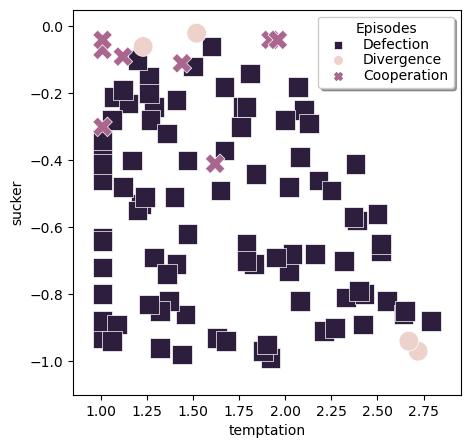

In [351]:
df_episodic_SG_1.loc[df_episodic_SG_1.isna().any(axis=1), 'agent1_final_strategy'] = -1
df_episodic_SG_1.loc[df_episodic_SG_1.isna().any(axis=1), 'agent2_final_strategy'] = -1
plt.figure(figsize=(5, 5))
ax = sns.scatterplot(data=df_episodic_SG_1.sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200,200], style='agent1_final_strategy', 
                markers=['o','X','s'], linewidth=0.5, alpha=1)

# markerprops = dict(markeredgewidth=1.25, markeredgecolor='black', markersize=7, markerfacecolor='none')
# handles, labels = ax.get_legend_handles_labels()
# for h in handles:
#     h.set(**markerprops)
    
lgnd = plt.legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Divergence','Cooperation'], loc='upper right', shadow=True)
plt.xlim(0.85,2.95)
plt.ylim(-1.1,0.05)

#change the marker size manually for both lines
for i in lgnd.legendHandles:
    i._sizes = [30]


SG 2 \
100it [52:47, 31.68s/it]

In [352]:
reward, temptation, sucker, punishment = generate_payoff_matrix('PD', N=100)
k = 1000
config['h'] = 5
config['n_episodes'] = 30000  # convergent threshold
thresh_strategy = k * config['min_epsilon'] + 5
thresh_network = k/100
thresh_reward = 1
thresh = (thresh_strategy, thresh_reward, thresh_network)

df_episodic_SG_2 = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                   'agent2_strategy', 'agent2_reward', 
                                   'temptation', 'reward', 'punishment', 'sucker', 
                                   'agent1_final_strategy', 'agent1_defection_ratio',
                                   'agent2_final_strategy', 'agent2_defection_ratio',
                                   'agent1_updating_times', 'agent2_updating_times'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config['epsilon_decay'] = 0.99
    config_obj = Config(config)
    with HiddenPrints():
        env = StochasticGameEnvironment(config_obj, thresh=2)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthority(config_obj, agents, k, settlement_prob=0.005, update_times=20, episodic_flag=True, sg_flag=True)
        authority.env = env
        
        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_episodic_SG_2.loc[len(df_episodic_SG_2.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                            convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                            config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                            round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                            float(torch.sum(agent1.own_memory)/agent1.play_times),
                                            round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                            float(torch.sum(agent2.own_memory)/agent2.play_times),
                                            agents[0].updating_times[1], agents[1].updating_times[0]]

In [353]:
df_episodic_SG_1['thresh'] = 1
df_episodic_SG_2['thresh'] = 2
df_episodic_SG = pd.concat([df_episodic_SG_1,df_episodic_SG_2],ignore_index=True)
df_episodic_SG.to_csv('2_agent_SG.csv', index=False)

Text(0.5, 1.0, 'SG 3')

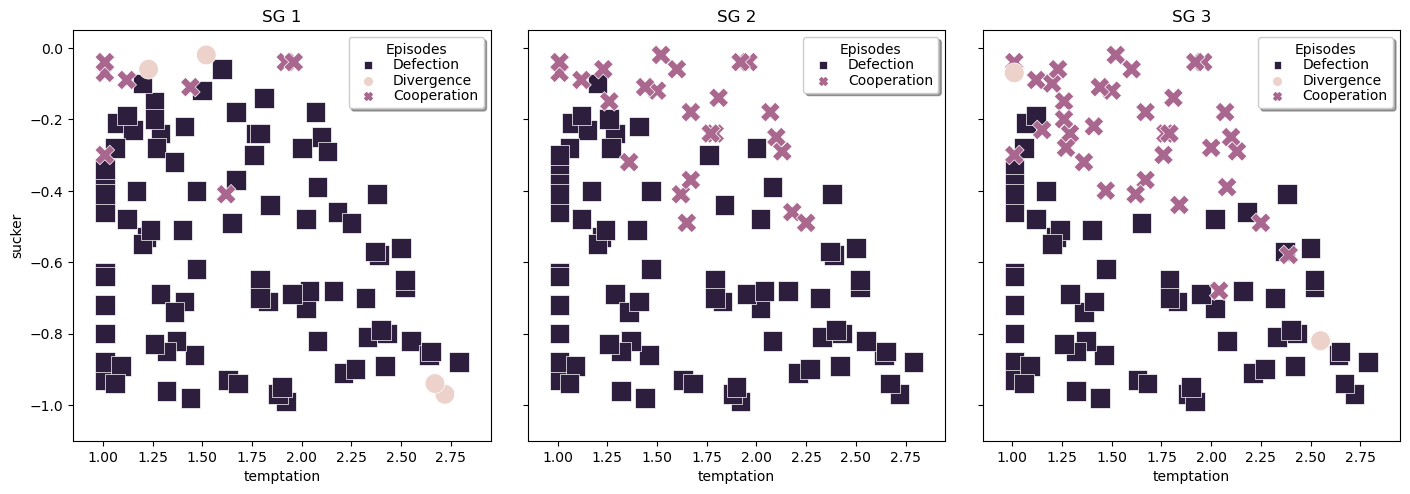

In [378]:
df_episodic_SG = pd.read_csv('2_agent_SG.csv')
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))

fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

sns.scatterplot(ax=axes[0], data=df_episodic_SG.loc[df_episodic_SG.thresh==1].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200,200], style='agent1_final_strategy', 
                markers=['o','X','s'], linewidth=0.5, alpha=1)
lgnd = axes[0].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Divergence','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
    
sns.scatterplot(ax=axes[1], data=df_episodic_SG.loc[df_episodic_SG.thresh==2].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200], style='agent1_final_strategy', 
                markers=['X','s'], linewidth=0.5, alpha=1, palette='ch:s=0,light=.5')
lgnd = axes[1].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
    
sns.scatterplot(ax=axes[2], data=df_episodic_SG.loc[df_episodic_SG.thresh==3].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200,200], style='agent1_final_strategy', 
                markers=['o','X','s'], linewidth=0.5, alpha=1)
lgnd = axes[2].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Divergence','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
    
axes[0].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[1].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[2].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[0].set_title('SG 1')
axes[1].set_title('SG 2')
axes[2].set_title('SG 3')